# Part 1: To mel spectogram+ train
## Method

Step 1: convert the audio files into Mel Spectrograms as images.

Step 2: Use Mel Spectrograms as the new dataset to classify the genres. Use a pretrained ResNet18 model for this task.

In [37]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import glob
import os
import librosa
import librosa.display
import torch
from torch import nn
from torchvision import models, transforms, datasets
from tqdm import tqdm
import IPython

## Defining audio parameters

In [3]:
path = "../input/gtzan-dataset-music-genre-classification/"
path_audio_files = path + "Data/genres_original/"
path_imgs = "./mel_spectrogram_imgs/"
batch_size = 32
hop_length = 512
n_fft = 2048
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

## Getting Mel Spectograms from Audio

In [4]:
## Transforming the Audio Files into Mel Spectrograms
print("transforming")
mel_spectogram_data = {}
for genre in tqdm(genre_dict.keys()): 
    
    mel_spectogram_data[genre] = []
    for name in glob.glob(path_audio_files + genre + "/*"):
        ## removing  file with unknown format
        if(name != "../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav"):
            data,sampling_rate = librosa.load(name)
            mel_spec = librosa.feature.melspectrogram(y = data.ravel(), 
                                                      sr=sampling_rate,
                                                      hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
            mel_spectogram_data[genre].append(mel_spec_db)
            

print("Saving Images")
## Save Mel Spectrogram images           
try:
    os.mkdir(path_imgs)
except:
    print("directory exists")  
for genre in tqdm(genre_dict.keys()):
    try:
        os.mkdir(path_imgs + genre)
    except:
        pass    
    for i in range(len(mel_spectogram_data[genre])):
        fig, ax = plt.subplots(1, figsize=(12,8))
        img = librosa.display.specshow(mel_spectogram_data[genre][i],
                                       sr = sampling_rate, 
                                       hop_length = hop_length,
                                       cmap = 'gray',ax=ax)
        fig.savefig(path_imgs + genre + "/" + genre + "_" + str(i) + ".png")
        plt.close()

transforming


100%|██████████| 10/10 [01:34<00:00,  9.40s/it]


Saving Images


100%|██████████| 10/10 [02:50<00:00, 17.08s/it]


In [5]:
import gc
gc.collect()

2037949

## Load and Transform the Data

In [6]:
# Define Tranforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

# Load the data
train_dataset = datasets.ImageFolder(path_imgs, transform = train_transform)
val_dataset = datasets.ImageFolder(path_imgs, transform = test_transform)
test_dataset = datasets.ImageFolder(path_imgs, transform = test_transform)


torch.manual_seed(1)
num_train_samples = len(train_dataset)

# Shuffle
indices = torch.randperm(num_train_samples)

# Train and Validation Split
train_testval_split = 0.2
train_split = int(num_train_samples * train_testval_split)
val_split = int(train_split * 0.5)

train_subset = torch.utils.data.Subset(train_dataset, indices[train_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[val_split:train_split])
test_subset = torch.utils.data.Subset(test_dataset, indices[:val_split])


print(f"Train Size:{len(train_subset)}; Validation Size:{len(val_subset)}; Test Size:{len(test_subset)}")

# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataloader.dataset.dataset.classes

Train Size:800; Validation Size:100; Test Size:99


In [7]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dataloader)

## ResNet18 - Transfer Learning

In [45]:
# Load Resnet 18 pretrained
resnet = models.resnet18(pretrained=True).cuda()
for parameter in resnet.parameters():
    parameter.requires_grad = False
    
    
# Replacing the last Layer
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(classes)).cuda()
nn.init.kaiming_uniform_(fc.weight.data) 
resnet.fc = fc


# Define the Loss and Optimizer Functions
endparams = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        endparams.append(param)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(endparams, lr=0.001)

## Training the Model

In [46]:
def train(model, criterion, optimizer, train_dataloader,test_dataloader,num_epochs):
    
    train_losses, val_losses = [], []
    
    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        ## calculate validation accuracy and loss
        with torch.no_grad():
            model.eval()
            correct_val, total_val = 0, 0
            val_loss = 0
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()

                correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                total_val += labels.size(0)
        
        ## Logging
        print(f'Epoch {epoch + 1}.', end=' ')
        print(f'Train loss {running_loss / total_train:.3f}.', end=' ')
        print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
        print(f'Val loss {val_loss / total_val :.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')


        train_losses.append(running_loss / total_train)
        val_losses.append(val_loss / total_val)


        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
    
    #return updated model and losses
    return model, train_losses, val_losses

In [47]:
num_epochs = 30

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    num_epochs=num_epochs
)

  3%|▎         | 1/30 [00:20<10:06, 20.92s/it]

Epoch 1. Train loss 0.074. Train acc 18.375. Val loss 0.086. Val acc 29.000. 

  7%|▋         | 2/30 [00:41<09:45, 20.91s/it]

Epoch 2. Train loss 0.063. Train acc 30.125. Val loss 0.075. Val acc 40.000. 

 10%|█         | 3/30 [01:02<09:20, 20.76s/it]

Epoch 3. Train loss 0.056. Train acc 38.375. Val loss 0.068. Val acc 43.000. 

 13%|█▎        | 4/30 [01:23<09:02, 20.86s/it]

Epoch 4. Train loss 0.052. Train acc 47.000. Val loss 0.062. Val acc 46.000. 

 17%|█▋        | 5/30 [01:44<08:41, 20.87s/it]

Epoch 5. Train loss 0.049. Train acc 51.250. Val loss 0.057. Val acc 51.000. 

 20%|██        | 6/30 [02:04<08:18, 20.78s/it]

Epoch 6. Train loss 0.046. Train acc 54.625. Val loss 0.056. Val acc 54.000. 

 23%|██▎       | 7/30 [02:25<07:58, 20.79s/it]

Epoch 7. Train loss 0.043. Train acc 57.750. Val loss 0.053. Val acc 50.000. 

 27%|██▋       | 8/30 [02:46<07:35, 20.72s/it]

Epoch 8. Train loss 0.042. Train acc 57.500. Val loss 0.050. Val acc 56.000. 

 30%|███       | 9/30 [03:06<07:13, 20.66s/it]

Epoch 9. Train loss 0.040. Train acc 60.625. Val loss 0.049. Val acc 63.000. 

 33%|███▎      | 10/30 [03:27<06:54, 20.72s/it]

Epoch 10. Train loss 0.039. Train acc 62.250. Val loss 0.046. Val acc 61.000. 

 37%|███▋      | 11/30 [03:48<06:33, 20.73s/it]

Epoch 11. Train loss 0.038. Train acc 63.750. Val loss 0.046. Val acc 65.000. 

 40%|████      | 12/30 [04:09<06:14, 20.82s/it]

Epoch 12. Train loss 0.036. Train acc 64.875. Val loss 0.048. Val acc 61.000. 

 43%|████▎     | 13/30 [04:31<05:58, 21.06s/it]

Epoch 13. Train loss 0.036. Train acc 65.500. Val loss 0.048. Val acc 61.000. 

 47%|████▋     | 14/30 [04:52<05:38, 21.13s/it]

Epoch 14. Train loss 0.036. Train acc 63.625. Val loss 0.043. Val acc 66.000. 

 50%|█████     | 15/30 [05:13<05:16, 21.08s/it]

Epoch 15. Train loss 0.034. Train acc 65.875. Val loss 0.044. Val acc 65.000. 

 53%|█████▎    | 16/30 [05:34<04:56, 21.15s/it]

Epoch 16. Train loss 0.034. Train acc 67.250. Val loss 0.045. Val acc 57.000. 

 57%|█████▋    | 17/30 [05:55<04:35, 21.18s/it]

Epoch 17. Train loss 0.033. Train acc 68.625. Val loss 0.040. Val acc 69.000. 

 60%|██████    | 18/30 [06:16<04:12, 21.03s/it]

Epoch 18. Train loss 0.032. Train acc 68.625. Val loss 0.039. Val acc 69.000. 

 63%|██████▎   | 19/30 [06:37<03:50, 20.94s/it]

Epoch 19. Train loss 0.032. Train acc 68.625. Val loss 0.040. Val acc 68.000. 

 67%|██████▋   | 20/30 [06:58<03:28, 20.89s/it]

Epoch 20. Train loss 0.031. Train acc 69.875. Val loss 0.040. Val acc 66.000. 

 70%|███████   | 21/30 [07:18<03:06, 20.78s/it]

Epoch 21. Train loss 0.031. Train acc 68.625. Val loss 0.039. Val acc 72.000. 

 73%|███████▎  | 22/30 [07:39<02:46, 20.77s/it]

Epoch 22. Train loss 0.030. Train acc 69.875. Val loss 0.040. Val acc 68.000. 

 77%|███████▋  | 23/30 [08:00<02:25, 20.81s/it]

Epoch 23. Train loss 0.029. Train acc 72.000. Val loss 0.038. Val acc 70.000. 

 80%|████████  | 24/30 [08:20<02:04, 20.79s/it]

Epoch 24. Train loss 0.029. Train acc 71.375. Val loss 0.040. Val acc 67.000. 

 83%|████████▎ | 25/30 [08:41<01:43, 20.76s/it]

Epoch 25. Train loss 0.029. Train acc 73.750. Val loss 0.039. Val acc 69.000. 

 87%|████████▋ | 26/30 [09:02<01:23, 20.80s/it]

Epoch 26. Train loss 0.028. Train acc 73.750. Val loss 0.038. Val acc 71.000. 

 90%|█████████ | 27/30 [09:23<01:02, 20.70s/it]

Epoch 27. Train loss 0.028. Train acc 74.500. Val loss 0.037. Val acc 72.000. 

 93%|█████████▎| 28/30 [09:43<00:41, 20.77s/it]

Epoch 28. Train loss 0.027. Train acc 73.625. Val loss 0.039. Val acc 64.000. 

 97%|█████████▋| 29/30 [10:04<00:20, 20.77s/it]

Epoch 29. Train loss 0.027. Train acc 74.375. Val loss 0.037. Val acc 71.000. 

100%|██████████| 30/30 [10:25<00:00, 20.85s/it]

Epoch 30. Train loss 0.027. Train acc 74.875. Val loss 0.041. Val acc 66.000. 

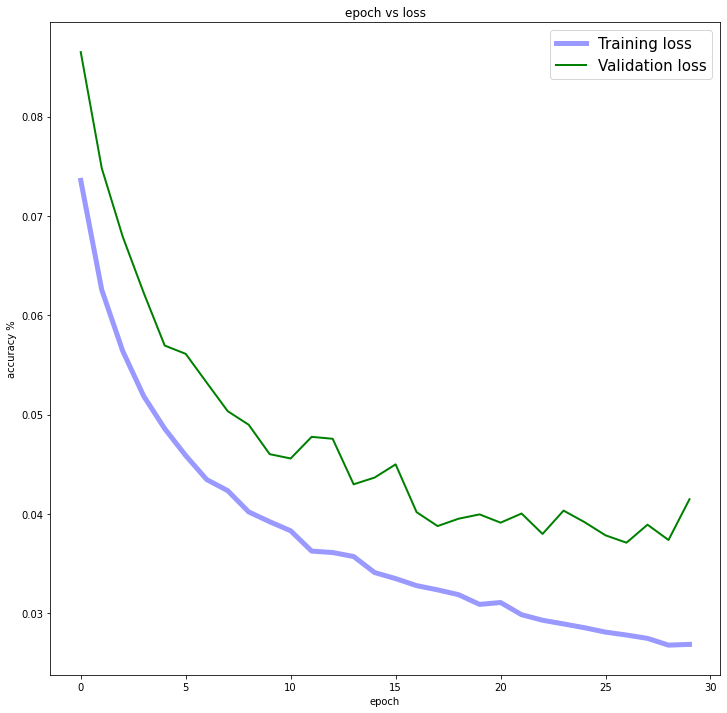

In [48]:
x= list(range(num_epochs))
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111)
ax.plot(x, train_losses, c='b', label='Training loss',linewidth=5.0,alpha=0.4)
ax.plot(x, val_losses, c='g', label='Validation loss',linewidth=2,alpha=1)
leg = plt.legend(prop={'size': 15})
plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("accuracy %")
plt.show()

## Testing

In [49]:
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet(img[None])
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])


In [50]:
print("Test Accuracy:",(round(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test),2)))

Test Accuracy: 69.7


In [51]:
gc.collect()

5566

# Part 2: Recommend based on Sample
## Method:
Sample some music from the test set. (This is assumed to be what the user already listens to.)

We will use this sample to recommend new music.

In [52]:
## sample 5 random music from test set (these 5 are assumed to be what the user already listens to and they have unknown genre)
usergenres=[]
usermusic_ind = random.randint(0,len(test_subset),5)
for i in usermusic_ind:
    img,lab = test_subset[i]
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet(img[None])
    genre = classes[torch.max(prediction, dim=1)[1]]
    usergenres.append(genre)
usergenres= list(set(usergenres))

In [53]:
print(usergenres)

['pop', 'jazz', 'disco']


In [54]:
'''
These recommendations will make more sense if the genre set and the music
dataset are bigger.for instance  in an audio streaming service like spotify
or apple music etc.
'''
def recommendation(usergenres, playlistsize=5):
    music_recommendations=[]
    recmusic_ind = random.randint(0,100,playlistsize)
    for i in range(playlistsize):
        ## select random genre from the user's genres
        x=random.randint(0,len(usergenres))
        gen=usergenres[x]
        ## sample music from that genre
        path=f"{gen}.000{int(recmusic_ind[i]/10)}{recmusic_ind[i]%10}"
        music_recommendations.append(path)
        
    return music_recommendations


In [55]:
#getting 5 recommendations
rec = recommendation(usergenres,5)
for i in rec:
    print(i)

disco.00003
jazz.00045
jazz.00013
disco.00051
jazz.00097
